In [1]:
# TensorFlow Imports
import tensorflow as tf
print(tf.__version__)

2.3.0


In [2]:
!nvidia-smi

Fri Aug 21 08:28:53 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    24W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!wget https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py

--2020-08-21 08:28:57--  https://raw.githubusercontent.com/GoogleCloudPlatform/keras-idiomatic-programmer/master/zoo/resnet/resnet_cifar10.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6064 (5.9K) [text/plain]
Saving to: ‘resnet_cifar10.py’

resnet_cifar10.py   100%[===================>]   5.92K  --.-KB/s    in 0s      

2020-08-21 08:28:57 (74.8 MB/s) - ‘resnet_cifar10.py’ saved [6064/6064]



In [4]:
!wget https://storage.googleapis.com/resnet-simclr-pseudo-labels/autoenc_resnet_simclr_cifar10.h5

--2020-08-21 08:29:02--  https://storage.googleapis.com/resnet-simclr-pseudo-labels/autoenc_resnet_simclr_cifar10.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 64.233.166.128, 74.125.133.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5085560 (4.8M) [application/octet-stream]
Saving to: ‘autoenc_resnet_simclr_cifar10.h5’

autoenc_resnet_simc 100%[===================>]   4.85M  --.-KB/s    in 0.04s   

2020-08-21 08:29:02 (126 MB/s) - ‘autoenc_resnet_simclr_cifar10.h5’ saved [5085560/5085560]



In [5]:
# Other imports
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
from imutils import paths
import tensorflow as tf
import seaborn as sns
import numpy as np
import resnet_cifar10
import cv2

# Random seed fixation
tf.random.set_seed(666)
np.random.seed(666)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [6]:
# Load the full set of CIFAR10
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Sample 10% for fine-tuning
train_indices = np.random.choice(len(x_train), 5000, replace=False)
x_train_frac = x_train[train_indices, :]
y_train_frac = y_train[train_indices, :]

# Prepare the dataset
x_train_frac = x_train_frac.astype("float32") / 255.
x_test = x_test.astype("float32") / 255.

170500096/170498071 [==============================] - 6s 0us/step


In [7]:
# ResNetCIFAR10
n = 4
depth =  n * 9 + 2
n_blocks = ((depth - 2) // 9) - 1

# The input tensor
inputs = Input(shape=(32, 32, 3))

# The Stem Convolution Group
x = resnet_cifar10.stem(inputs)
   
# The learner
outputs = resnet_cifar10.learner(x, n_blocks)

# Instantiate the Model
resnet_headless_model = Model(inputs, outputs)

In [8]:
# Architecture utils
def get_resnet_simclr_deeper(hidden_1, hidden_2, hidden_3):
    inputs = Input((32, 32, 3))
    h = resnet_headless_model(inputs, training=False)
    h = GlobalAveragePooling2D()(h)
    
    projection_1 = Dense(hidden_1)(h)
    projection_1 = Activation("relu")(projection_1)
    projection_2 = Dense(hidden_2)(projection_1)
    projection_2 = Activation("relu")(projection_2)
    projection_3 = Dense(hidden_3)(projection_2)

    resnet_simclr = Model(inputs, projection_3)

    return resnet_simclr

In [9]:
resnet_simclr = get_resnet_simclr_deeper(256, 128, 50)
resnet_simclr.load_weights("autoenc_resnet_simclr_cifar10.h5")
resnet_simclr.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_3 (Functional)    (None, 8, 8, 256)         1121344   
_________________________________________________________________
global_average_pooling2d (Gl (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
activation_1 (Activation)    (None, 128)              

In [10]:
def plot_training(H):
	with plt.xkcd():
		plt.plot(H.history["loss"], label="train_loss")
		plt.plot(H.history["val_loss"], label="val_loss")
		plt.plot(H.history["accuracy"], label="train_acc")
		plt.plot(H.history["val_accuracy"], label="val_acc")
		plt.title("Training Loss and Accuracy")
		plt.xlabel("Epoch #")
		plt.ylabel("Loss/Accuracy")
		plt.legend(loc="lower left")
		plt.show()

In [11]:
# Encoder model with no projection
extractor = Model(resnet_simclr.input, resnet_simclr.layers[-6].output) # weights are already loaded

def get_training_model(trainable=False):
    inputs = Input(shape=(32, 32, 3))
    extractor.trainable = trainable
    x = extractor(inputs, training=False)
    x = Dense(10, activation="softmax")(x)
    classifier = Model(inputs=inputs, outputs=x)
    
    return classifier

## Warmup

In [12]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2, verbose=2, restore_best_weights=True)

Epoch 1/35
79/79 [==============================] - 9s 110ms/step - loss: 2.9347 - accuracy: 0.1798 - val_loss: 2.1421 - val_accuracy: 0.2561
Epoch 2/35
79/79 [==============================] - 7s 94ms/step - loss: 2.0288 - accuracy: 0.2854 - val_loss: 1.9757 - val_accuracy: 0.2773
Epoch 3/35
79/79 [==============================] - 7s 94ms/step - loss: 1.9206 - accuracy: 0.3060 - val_loss: 1.9000 - val_accuracy: 0.3049
Epoch 4/35
79/79 [==============================] - 7s 93ms/step - loss: 1.8824 - accuracy: 0.3152 - val_loss: 1.9250 - val_accuracy: 0.3027
Epoch 5/35
79/79 [==============================] - 7s 94ms/step - loss: 1.8544 - accuracy: 0.3264 - val_loss: 1.8574 - val_accuracy: 0.3239
Epoch 6/35
79/79 [==============================] - 7s 94ms/step - loss: 1.8374 - accuracy: 0.3218 - val_loss: 1.8290 - val_accuracy: 0.3311
Epoch 7/35
79/79 [==============================] - 7s 93ms/step - loss: 1.8202 - accuracy: 0.3378 - val_loss: 1.8681 - val_accuracy: 0.3115
Epoch 8/35
7

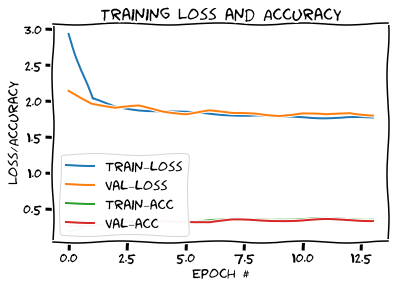

In [13]:
model = get_training_model()

model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer='adam')

history = model.fit(x_train_frac, y_train_frac,
                 validation_data=(x_test, y_test),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)

## Fine-tune

In [14]:
model.layers[1].trainable = True
model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
functional_7 (Functional)    (None, 256)               1121344   
_________________________________________________________________
dense_4 (Dense)              (None, 10)                2570      
Total params: 1,123,914
Trainable params: 1,116,970
Non-trainable params: 6,944
_________________________________________________________________


Epoch 1/35
79/79 [==============================] - 15s 190ms/step - loss: 1.7297 - accuracy: 0.3712 - val_loss: 1.7576 - val_accuracy: 0.3622
Epoch 2/35
79/79 [==============================] - 14s 175ms/step - loss: 1.7075 - accuracy: 0.3874 - val_loss: 1.7475 - val_accuracy: 0.3660
Epoch 3/35
79/79 [==============================] - 14s 175ms/step - loss: 1.6896 - accuracy: 0.3890 - val_loss: 1.7380 - val_accuracy: 0.3684
Epoch 4/35
79/79 [==============================] - 14s 175ms/step - loss: 1.6769 - accuracy: 0.3944 - val_loss: 1.7270 - val_accuracy: 0.3735
Epoch 5/35
79/79 [==============================] - 14s 174ms/step - loss: 1.6600 - accuracy: 0.4010 - val_loss: 1.7201 - val_accuracy: 0.3729
Epoch 6/35
79/79 [==============================] - 14s 176ms/step - loss: 1.6475 - accuracy: 0.4018 - val_loss: 1.7153 - val_accuracy: 0.3769
Epoch 7/35
79/79 [==============================] - 14s 178ms/step - loss: 1.6350 - accuracy: 0.4138 - val_loss: 1.7023 - val_accuracy: 0.3845

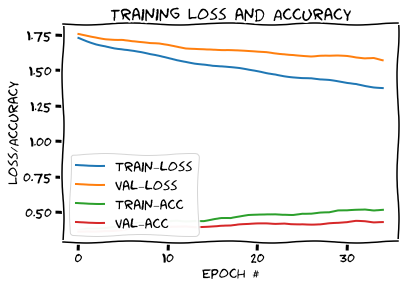

In [15]:
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"],
                     optimizer=tf.keras.optimizers.Adam(1e-5)) # Low learning rate

history = model.fit(x_train_frac, y_train_frac,
                 validation_data=(x_test, y_test),
                 batch_size=64,
                 epochs=35,
                 callbacks=[es])
plot_training(history)